In [ ]:
# import pandas as pd
# import xgboost as xgb

# # Cargar el dataset
# df = pd.read_csv('../data/ventas_featurev2.csv', sep=',')

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
import xgboost as xgb
import random

In [2]:
SEED = 26790882
random.seed(SEED)
np.random.seed(SEED)
# Leer muestra para detectar tipos
sample = pd.read_csv('../data/ventas_featurev4.csv', nrows=1000)
float_cols = sample.select_dtypes(include='float64').columns.tolist()
obj_cols = sample.select_dtypes(include='object').columns.tolist()

# Crear mapeo de tipos
dtype_map = {c: np.float32 for c in float_cols}
dtype_map.update({c: 'category' for c in obj_cols})
# Leer todo en tipos optimizados
df = pd.read_csv('../data/ventas_featurev4.csv', dtype=dtype_map)

# Verificar memoria y tipos
print(df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 97 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   periodo                    category
 1   customer_id                int64   
 2   product_id                 int64   
 3   plan_precios_cuidados      float32 
 4   tn                         float32 
 5   cust_request_qty           float32 
 6   cust_request_tn            float32 
 7   cat1                       category
 8   cat2                       category
 9   cat3                       category
 10  brand                      category
 11  sku_size                   int64   
 12  descripcion                category
 13  productos_estrella         int64   
 14  mes                        int64   
 15  catastrofe                 int64   
 16  cliente_estrella           int64   
 17  prod_cust                  category
 18  tn_lag_1                   float32 
 19  tn_lag_2           

In [3]:
# Convertir 'periodo' de fecha a entero tipo YYYYMM
df["periodo"] = pd.to_datetime(df["periodo"])
df["periodo"] = df["periodo"].dt.strftime("%Y%m").astype(int)

In [4]:
df = df.apply(lambda col: col.astype('int32') if col.dtype == 'int64' else col)

In [8]:
df_train = df[df["periodo"] <= 201912].copy()

# Features de entrada
drop_cols = ["tn", "tn_mas_2", "periodo", "descripcion", "prod_cust"]  # prod_cust parece ID compuesto
X_train = df_train.drop(columns=drop_cols, errors="ignore")
y_train = df_train["tn"]

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Definimos la función objetivo
def objective(trial):
    # Hiperparámetros a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "tree_method": "hist",
        "enable_categorical": True,
        "early_stopping_rounds": 20,
        "objective": "reg:squarederror"
    }

    model = XGBRegressor(**params)

    # Separación fija: validación últimos 3 meses antes de 2020
    val_mask = df_train["periodo"] >= 201910
    X_val, y_val = X_train[val_mask], y_train[val_mask]
    X_train_model, y_train_model = X_train[~val_mask], y_train[~val_mask]

    model.fit(
        X_train_model,
        y_train_model,
        eval_set=[(X_val, y_val)],
        verbose=True
    )

    # Predicción y evaluación
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Crear el estudio y optimizar
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Resultados
print("Mejores hiperparámetros:")
print(study.best_params)
print("Mejor RMSE:")
print(study.best_value)


[I 2025-07-01 20:38:49,701] A new study created in memory with name: no-name-e171f582-da25-4fdf-93e6-4a3da12c91fa


[0]	validation_0-rmse:1.18300
[1]	validation_0-rmse:1.01595
[2]	validation_0-rmse:0.92778
[3]	validation_0-rmse:0.86481
[4]	validation_0-rmse:0.81340
[5]	validation_0-rmse:0.77375
[6]	validation_0-rmse:0.74142
[7]	validation_0-rmse:0.70159
[8]	validation_0-rmse:0.66953
[9]	validation_0-rmse:0.66568
[10]	validation_0-rmse:0.65722
[11]	validation_0-rmse:0.64696
[12]	validation_0-rmse:0.64480
[13]	validation_0-rmse:0.64181
[14]	validation_0-rmse:0.63442
[15]	validation_0-rmse:0.62814
[16]	validation_0-rmse:0.62460
[17]	validation_0-rmse:0.61982
[18]	validation_0-rmse:0.61562
[19]	validation_0-rmse:0.61140
[20]	validation_0-rmse:0.60808
[21]	validation_0-rmse:0.60529
[22]	validation_0-rmse:0.60281
[23]	validation_0-rmse:0.59964
[24]	validation_0-rmse:0.59760
[25]	validation_0-rmse:0.59576
[26]	validation_0-rmse:0.59394
[27]	validation_0-rmse:0.59243
[28]	validation_0-rmse:0.59050
[29]	validation_0-rmse:0.58759
[30]	validation_0-rmse:0.58543
[31]	validation_0-rmse:0.58391
[32]	validation_0-

[I 2025-07-01 20:41:24,480] Trial 0 finished with value: 0.5036108644555823 and parameters: {'n_estimators': 245, 'learning_rate': 0.29233923760802805, 'max_depth': 7, 'subsample': 0.7639568768981859, 'colsample_bytree': 0.5578183449267715, 'gamma': 0.41606557853233306, 'reg_alpha': 1.4010297526087556, 'reg_lambda': 4.793559798841741}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.29766
[1]	validation_0-rmse:1.19676
[2]	validation_0-rmse:1.10903
[3]	validation_0-rmse:1.03806
[4]	validation_0-rmse:0.98754
[5]	validation_0-rmse:0.95441
[6]	validation_0-rmse:0.91060
[7]	validation_0-rmse:0.88639
[8]	validation_0-rmse:0.86186
[9]	validation_0-rmse:0.83846
[10]	validation_0-rmse:0.82356
[11]	validation_0-rmse:0.80419
[12]	validation_0-rmse:0.79400
[13]	validation_0-rmse:0.78703
[14]	validation_0-rmse:0.77294
[15]	validation_0-rmse:0.76559
[16]	validation_0-rmse:0.75680
[17]	validation_0-rmse:0.75150
[18]	validation_0-rmse:0.74211
[19]	validation_0-rmse:0.73289
[20]	validation_0-rmse:0.72453
[21]	validation_0-rmse:0.71748
[22]	validation_0-rmse:0.71207
[23]	validation_0-rmse:0.70824
[24]	validation_0-rmse:0.70344
[25]	validation_0-rmse:0.70013
[26]	validation_0-rmse:0.69436
[27]	validation_0-rmse:0.68978
[28]	validation_0-rmse:0.68205
[29]	validation_0-rmse:0.67707
[30]	validation_0-rmse:0.67124
[31]	validation_0-rmse:0.67049
[32]	validation_0-

[I 2025-07-01 20:44:46,977] Trial 1 finished with value: 0.5151337103733246 and parameters: {'n_estimators': 295, 'learning_rate': 0.13758338054228358, 'max_depth': 5, 'subsample': 0.5475803665104082, 'colsample_bytree': 0.70220019173951, 'gamma': 4.909851336615739, 'reg_alpha': 6.924886722356503, 'reg_lambda': 2.0253355492936476}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.19369
[1]	validation_0-rmse:1.04270
[2]	validation_0-rmse:0.94927
[3]	validation_0-rmse:0.88526
[4]	validation_0-rmse:0.84692
[5]	validation_0-rmse:0.82065
[6]	validation_0-rmse:0.79020
[7]	validation_0-rmse:0.77460
[8]	validation_0-rmse:0.75426
[9]	validation_0-rmse:0.74186
[10]	validation_0-rmse:0.73228
[11]	validation_0-rmse:0.71599
[12]	validation_0-rmse:0.70792
[13]	validation_0-rmse:0.70395
[14]	validation_0-rmse:0.69628
[15]	validation_0-rmse:0.68911
[16]	validation_0-rmse:0.68328
[17]	validation_0-rmse:0.67937
[18]	validation_0-rmse:0.67551
[19]	validation_0-rmse:0.67238
[20]	validation_0-rmse:0.66524
[21]	validation_0-rmse:0.66214
[22]	validation_0-rmse:0.65944
[23]	validation_0-rmse:0.65695
[24]	validation_0-rmse:0.65476
[25]	validation_0-rmse:0.65276
[26]	validation_0-rmse:0.64989
[27]	validation_0-rmse:0.64828
[28]	validation_0-rmse:0.64638
[29]	validation_0-rmse:0.64337
[30]	validation_0-rmse:0.64197
[31]	validation_0-rmse:0.64069
[32]	validation_0-

[I 2025-07-01 20:46:13,031] Trial 2 finished with value: 0.61189918536509 and parameters: {'n_estimators': 62, 'learning_rate': 0.250767965271403, 'max_depth': 5, 'subsample': 0.8162846200007203, 'colsample_bytree': 0.927569160592105, 'gamma': 0.3642497041743187, 'reg_alpha': 5.36775423564234, 'reg_lambda': 4.514990038441536}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.38483
[1]	validation_0-rmse:1.35751
[2]	validation_0-rmse:1.33113
[3]	validation_0-rmse:1.30682
[4]	validation_0-rmse:1.28468
[5]	validation_0-rmse:1.26694
[6]	validation_0-rmse:1.24362
[7]	validation_0-rmse:1.22170
[8]	validation_0-rmse:1.20144
[9]	validation_0-rmse:1.18100
[10]	validation_0-rmse:1.16473
[11]	validation_0-rmse:1.14699
[12]	validation_0-rmse:1.13455
[13]	validation_0-rmse:1.11885
[14]	validation_0-rmse:1.10249
[15]	validation_0-rmse:1.08910
[16]	validation_0-rmse:1.07834
[17]	validation_0-rmse:1.06444
[18]	validation_0-rmse:1.04973
[19]	validation_0-rmse:1.03640
[20]	validation_0-rmse:1.02225
[21]	validation_0-rmse:1.00963
[22]	validation_0-rmse:1.00064
[23]	validation_0-rmse:0.98878
[24]	validation_0-rmse:0.97845
[25]	validation_0-rmse:0.97147
[26]	validation_0-rmse:0.96023
[27]	validation_0-rmse:0.95128
[28]	validation_0-rmse:0.94268
[29]	validation_0-rmse:0.93434
[30]	validation_0-rmse:0.92618
[31]	validation_0-rmse:0.91840
[32]	validation_0-

[I 2025-07-01 20:49:09,971] Trial 3 finished with value: 0.647364199216626 and parameters: {'n_estimators': 249, 'learning_rate': 0.031805628265708805, 'max_depth': 5, 'subsample': 0.886931524854591, 'colsample_bytree': 0.7597516108998632, 'gamma': 2.8047829568292015, 'reg_alpha': 3.9492407229014437, 'reg_lambda': 5.03083408001518}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.21306
[1]	validation_0-rmse:1.07307
[2]	validation_0-rmse:0.96157
[3]	validation_0-rmse:0.88907
[4]	validation_0-rmse:0.83716
[5]	validation_0-rmse:0.79282
[6]	validation_0-rmse:0.76239
[7]	validation_0-rmse:0.73469
[8]	validation_0-rmse:0.69907
[9]	validation_0-rmse:0.67629
[10]	validation_0-rmse:0.66204
[11]	validation_0-rmse:0.65269
[12]	validation_0-rmse:0.64428
[13]	validation_0-rmse:0.63684
[14]	validation_0-rmse:0.63495
[15]	validation_0-rmse:0.63080
[16]	validation_0-rmse:0.62980
[17]	validation_0-rmse:0.62417
[18]	validation_0-rmse:0.62255
[19]	validation_0-rmse:0.61950
[20]	validation_0-rmse:0.61585
[21]	validation_0-rmse:0.61384
[22]	validation_0-rmse:0.61157
[23]	validation_0-rmse:0.61096
[24]	validation_0-rmse:0.60925
[25]	validation_0-rmse:0.60733
[26]	validation_0-rmse:0.60484
[27]	validation_0-rmse:0.60280
[28]	validation_0-rmse:0.60060
[29]	validation_0-rmse:0.59837
[30]	validation_0-rmse:0.59737
[31]	validation_0-rmse:0.59531
[32]	validation_0-

[I 2025-07-01 20:50:55,130] Trial 4 finished with value: 0.530223977608203 and parameters: {'n_estimators': 100, 'learning_rate': 0.22345954300641205, 'max_depth': 7, 'subsample': 0.7143332519500405, 'colsample_bytree': 0.8404578087036879, 'gamma': 3.9835970991921155, 'reg_alpha': 5.221988109253384, 'reg_lambda': 9.770048634571095}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.19126
[1]	validation_0-rmse:1.02292
[2]	validation_0-rmse:0.91161
[3]	validation_0-rmse:0.83158
[4]	validation_0-rmse:0.77489
[5]	validation_0-rmse:0.74757
[6]	validation_0-rmse:0.72012
[7]	validation_0-rmse:0.69711
[8]	validation_0-rmse:0.68230
[9]	validation_0-rmse:0.66215
[10]	validation_0-rmse:0.65104
[11]	validation_0-rmse:0.63245
[12]	validation_0-rmse:0.62387
[13]	validation_0-rmse:0.62061
[14]	validation_0-rmse:0.61912
[15]	validation_0-rmse:0.61404
[16]	validation_0-rmse:0.61007
[17]	validation_0-rmse:0.60739
[18]	validation_0-rmse:0.60452
[19]	validation_0-rmse:0.60217
[20]	validation_0-rmse:0.60049
[21]	validation_0-rmse:0.59797
[22]	validation_0-rmse:0.59508
[23]	validation_0-rmse:0.59290
[24]	validation_0-rmse:0.59146
[25]	validation_0-rmse:0.58998
[26]	validation_0-rmse:0.58926
[27]	validation_0-rmse:0.58759
[28]	validation_0-rmse:0.58591
[29]	validation_0-rmse:0.58453
[30]	validation_0-rmse:0.58335
[31]	validation_0-rmse:0.58204
[32]	validation_0-

[I 2025-07-01 20:52:46,818] Trial 5 finished with value: 0.5454794652711933 and parameters: {'n_estimators': 103, 'learning_rate': 0.2706897550792082, 'max_depth': 10, 'subsample': 0.9163126873480458, 'colsample_bytree': 0.7477315974938612, 'gamma': 3.254819925997425, 'reg_alpha': 0.7369706718763047, 'reg_lambda': 6.603249115971007}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.25864
[1]	validation_0-rmse:1.13857
[2]	validation_0-rmse:1.03010
[3]	validation_0-rmse:0.94989
[4]	validation_0-rmse:0.87623
[5]	validation_0-rmse:0.81626
[6]	validation_0-rmse:0.77158
[7]	validation_0-rmse:0.73252
[8]	validation_0-rmse:0.70086
[9]	validation_0-rmse:0.67634
[10]	validation_0-rmse:0.65887
[11]	validation_0-rmse:0.63754
[12]	validation_0-rmse:0.62488
[13]	validation_0-rmse:0.61013
[14]	validation_0-rmse:0.59893
[15]	validation_0-rmse:0.58817
[16]	validation_0-rmse:0.58308
[17]	validation_0-rmse:0.57714
[18]	validation_0-rmse:0.57281
[19]	validation_0-rmse:0.56949
[20]	validation_0-rmse:0.56455
[21]	validation_0-rmse:0.56124
[22]	validation_0-rmse:0.55671
[23]	validation_0-rmse:0.55302
[24]	validation_0-rmse:0.55020
[25]	validation_0-rmse:0.54712
[26]	validation_0-rmse:0.54500
[27]	validation_0-rmse:0.54263
[28]	validation_0-rmse:0.54098
[29]	validation_0-rmse:0.53952
[30]	validation_0-rmse:0.53792
[31]	validation_0-rmse:0.53651
[32]	validation_0-

[I 2025-07-01 20:54:33,712] Trial 6 finished with value: 0.5202276681930867 and parameters: {'n_estimators': 221, 'learning_rate': 0.15817881542673698, 'max_depth': 12, 'subsample': 0.9991555181465807, 'colsample_bytree': 0.9462524578892848, 'gamma': 1.0174621115904081, 'reg_alpha': 0.014273710581471644, 'reg_lambda': 1.731451284034804}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.33249
[1]	validation_0-rmse:1.25089
[2]	validation_0-rmse:1.19193
[3]	validation_0-rmse:1.13060
[4]	validation_0-rmse:1.07510
[5]	validation_0-rmse:1.03063
[6]	validation_0-rmse:0.98698
[7]	validation_0-rmse:0.94058
[8]	validation_0-rmse:0.89481
[9]	validation_0-rmse:0.86819
[10]	validation_0-rmse:0.84840
[11]	validation_0-rmse:0.82467
[12]	validation_0-rmse:0.80538
[13]	validation_0-rmse:0.78512
[14]	validation_0-rmse:0.76034
[15]	validation_0-rmse:0.74493
[16]	validation_0-rmse:0.73410
[17]	validation_0-rmse:0.71810
[18]	validation_0-rmse:0.70281
[19]	validation_0-rmse:0.68559
[20]	validation_0-rmse:0.67081
[21]	validation_0-rmse:0.66363
[22]	validation_0-rmse:0.65209
[23]	validation_0-rmse:0.64268
[24]	validation_0-rmse:0.63581
[25]	validation_0-rmse:0.63092
[26]	validation_0-rmse:0.62564
[27]	validation_0-rmse:0.62283
[28]	validation_0-rmse:0.61446
[29]	validation_0-rmse:0.60878
[30]	validation_0-rmse:0.60298
[31]	validation_0-rmse:0.59922
[32]	validation_0-

[I 2025-07-01 20:57:14,282] Trial 7 finished with value: 0.5135572182220199 and parameters: {'n_estimators': 248, 'learning_rate': 0.09162724461899255, 'max_depth': 10, 'subsample': 0.942136507427616, 'colsample_bytree': 0.5161332749274079, 'gamma': 1.3597555228526286, 'reg_alpha': 3.178522256231624, 'reg_lambda': 1.3181075294859412}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.38368
[1]	validation_0-rmse:1.35519
[2]	validation_0-rmse:1.32771
[3]	validation_0-rmse:1.30255
[4]	validation_0-rmse:1.27952
[5]	validation_0-rmse:1.26124
[6]	validation_0-rmse:1.23709
[7]	validation_0-rmse:1.21430
[8]	validation_0-rmse:1.19440
[9]	validation_0-rmse:1.17326
[10]	validation_0-rmse:1.15635
[11]	validation_0-rmse:1.13824
[12]	validation_0-rmse:1.12556
[13]	validation_0-rmse:1.10975
[14]	validation_0-rmse:1.09370
[15]	validation_0-rmse:1.08006
[16]	validation_0-rmse:1.06835
[17]	validation_0-rmse:1.05369
[18]	validation_0-rmse:1.03869
[19]	validation_0-rmse:1.02516
[20]	validation_0-rmse:1.01073
[21]	validation_0-rmse:0.99803
[22]	validation_0-rmse:0.98901
[23]	validation_0-rmse:0.97708
[24]	validation_0-rmse:0.96675
[25]	validation_0-rmse:0.95974
[26]	validation_0-rmse:0.94832
[27]	validation_0-rmse:0.93939
[28]	validation_0-rmse:0.93035
[29]	validation_0-rmse:0.92195
[30]	validation_0-rmse:0.91378
[31]	validation_0-rmse:0.90663
[32]	validation_0-

[I 2025-07-01 20:59:55,389] Trial 8 finished with value: 0.6361167261504213 and parameters: {'n_estimators': 201, 'learning_rate': 0.03289516099453843, 'max_depth': 5, 'subsample': 0.8697471632295162, 'colsample_bytree': 0.7669521796623063, 'gamma': 2.7875088106673918, 'reg_alpha': 9.347291653169389, 'reg_lambda': 1.9271192264717096}. Best is trial 0 with value: 0.5036108644555823.


[0]	validation_0-rmse:1.17972
[1]	validation_0-rmse:1.01818
[2]	validation_0-rmse:0.91455
[3]	validation_0-rmse:0.84349
[4]	validation_0-rmse:0.78249
[5]	validation_0-rmse:0.74477
[6]	validation_0-rmse:0.72120
[7]	validation_0-rmse:0.69969
[8]	validation_0-rmse:0.69084
[9]	validation_0-rmse:0.66989
[10]	validation_0-rmse:0.65972
[11]	validation_0-rmse:0.64136
[12]	validation_0-rmse:0.63714
[13]	validation_0-rmse:0.63409
[14]	validation_0-rmse:0.62609
[15]	validation_0-rmse:0.62039
[16]	validation_0-rmse:0.61447
[17]	validation_0-rmse:0.61008
[18]	validation_0-rmse:0.60662
[19]	validation_0-rmse:0.60361
[20]	validation_0-rmse:0.59962
[21]	validation_0-rmse:0.59729
[22]	validation_0-rmse:0.59488
[23]	validation_0-rmse:0.59305
[24]	validation_0-rmse:0.59142
[25]	validation_0-rmse:0.58995
[26]	validation_0-rmse:0.58803
[27]	validation_0-rmse:0.58687
[28]	validation_0-rmse:0.58428
[29]	validation_0-rmse:0.58322
[30]	validation_0-rmse:0.58230
[31]	validation_0-rmse:0.58150
[32]	validation_0-

[I 2025-07-01 21:01:25,030] Trial 9 finished with value: 0.5352766082631899 and parameters: {'n_estimators': 71, 'learning_rate': 0.2567532532443774, 'max_depth': 6, 'subsample': 0.8773699062701046, 'colsample_bytree': 0.950228727824061, 'gamma': 3.444675237696688, 'reg_alpha': 9.373020353760332, 'reg_lambda': 3.0750257796857037}. Best is trial 0 with value: 0.5036108644555823.


Mejores hiperparámetros:
{'n_estimators': 245, 'learning_rate': 0.29233923760802805, 'max_depth': 7, 'subsample': 0.7639568768981859, 'colsample_bytree': 0.5578183449267715, 'gamma': 0.41606557853233306, 'reg_alpha': 1.4010297526087556, 'reg_lambda': 4.793559798841741}
Mejor RMSE:
0.5036108644555823


In [ ]:
# 1. Obtener los mejores hiperparámetros del estudio
best_params = study.best_params

# 2. Agregar los parámetros fijos que no se optimizaron
best_params.update({
    "tree_method": "hist",
    "enable_categorical": True,
    "objective": "reg:squarederror",
    "random_state": 42
})

# 3. Entrenar modelo final con los mejores hiperparámetros
model_final = XGBRegressor(**best_params)

# Usamos todos los datos disponibles hasta 202001 inclusive
mask_final_train = df_train["periodo"] <= 202001
X_final_train = X_train[mask_final_train]
y_final_train = y_train[mask_final_train]

model_final.fit(X_final_train, y_final_train)




In [14]:
df_201912 = df[df["periodo"] == 201912].copy()
df_pred = df_201912.copy()
df_pred["periodo"] = 202002  # Simulamos el período futuro

In [15]:
X_pred = df_pred.drop(columns=["periodo", "descripcion", "prod_cust","tn", "tn_mas_2"], errors="ignore")

In [16]:
# 4. Hacer predicciones sobre 202002
df_pred["tn_pred"] = model_final.predict(X_pred)

# 5. Agrupar por product_id y exportar resultados
df_result = (
    df_pred.groupby("product_id")["tn_pred"]
    .sum()
    .reset_index()
    .rename(columns={"tn_pred": "tn"})
)

df_result.to_csv("../data/submission_xgboost_202002.csv", index=False)

print("✅ Archivo generado: submission_xgboost_202002.csv")

✅ Archivo generado: submission_xgboost_202002.csv


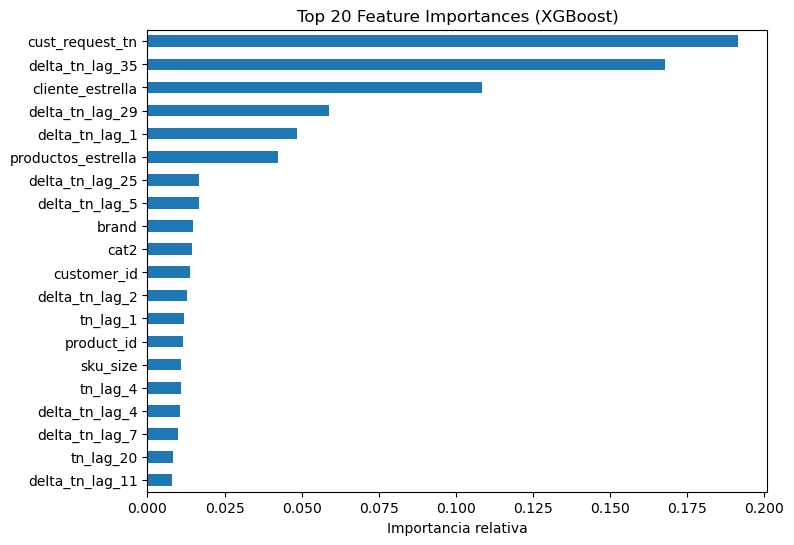

In [18]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# 2) Extrae importancias
importances = pd.Series(model_final.feature_importances_, index=X_train.columns)

# 3) Selecciona las top N (por ejemplo 15)
N = 20
topN = importances.nlargest(N).sort_values(ascending=True)

# 4) Grafica solo esas
plt.figure(figsize=(8,6))
topN.plot(kind='barh')
plt.title(f'Top {N} Feature Importances (XGBoost)')
plt.xlabel('Importancia relativa')
plt.show()